# EE511 Final Project

In this file we train the SqueezeNet model as described in the paper found [here](https://arxiv.org/abs/1602.07360).
This implementation uses the CIFAR10 dataset.

## Task 1: Train SqueezeNet

For task 1 we train SqueezeNet for 100 epochs and are able to get a final test accuracy of 69.66%.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.ao.quantization import QuantStub, DeQuantStub
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from collections import OrderedDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device={device}")

Device=cuda


## Implementation

The class in this cell below defines our architecture and defines our forward pass. We insert quantization stub for later Quantization Aware Training. We also define helper functions to save and load the model.

Note: MSR Initialization was added because the training would not work without it.

In [ ]:
import math
class Fire(nn.Module):
    def __init__(self, inplanes, squeeze_planes, expand_planes):
        super(Fire, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(squeeze_planes, expand_planes, kernel_size=1)
        self.conv3 = nn.Conv2d(squeeze_planes, expand_planes, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()

        # MSR initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        out1 = self.conv2(x)
        out2 = self.conv3(x)
        out = torch.cat([out1, out2], 1)
        out = self.relu2(out)
        return out

class SqueezeNetCIFAR10(nn.Module):
    def __init__(self, num_classes=10):
        super(SqueezeNetCIFAR10, self).__init__()
        self.quant = QuantStub()
        self.dequant = DeQuantStub()

        self.upsample = nn.Upsample(size=224, mode='bilinear', align_corners=False)

        self.conv1 = nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.fire2 = Fire(96, 16, 64)
        self.fire3 = Fire(128, 16, 64)
        self.fire4 = Fire(128, 32, 128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.fire5 = Fire(256, 32, 128)
        self.fire6 = Fire(256, 48, 192)
        self.fire7 = Fire(384, 48, 192)
        self.fire8 = Fire(384, 64, 256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.fire9 = Fire(512, 64, 256)
        self.conv10 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.avg_pool = nn.AvgPool2d(13)

    def forward(self, x):
        x = self.upsample(x)
        x = self.quant(x)
        x = self.maxpool1(self.conv1(x))

        x = self.fire2(x)
        x = self.fire3(x)
        x = self.fire4(x)
        x = self.maxpool2(x)

        x = self.fire5(x)
        x = self.fire6(x)
        x = self.fire7(x)
        x = self.fire8(x)
        x = self.maxpool3(x)

        x = self.fire9(x)
        x = self.conv10(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.dequant(x)
        return x
    
    def load_model(self, path='squeezenet_fp32.pth',device='cpu'):
        state_dict = torch.load(path,map_location=device)

        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            if k.startswith('module.'):
                k = k[len('module.'):]
            new_state_dict[k] = v

        self.load_state_dict(new_state_dict)
        self.to(device)
        self.eval()

        print(f"Model loaded from {path}")
        # print(self)

    def save_model(self, path='squeezenet_fp32.pth'):
        torch.save(self.state_dict(), path)
        print(f"Model saved to {path}")


## Load the Dataset

In this cell we define a function to load our dataset.

In [3]:
def load_dataset(path='./data', batch_size=64):
  print("Loading the CIFAR10 dataset")

  transform = transforms.Compose([
    transforms.ToTensor(), # scale RGB 0-255 to 0-1
    # normalize with known mean and std deviation of the CIFAR10 dataset
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))
  ])

  train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                    (0.2023, 0.1994, 0.2010)),
  ])

  # get training data
  train_dataset = datasets.CIFAR10(root=path, train=True, download=True, transform=train_transform)
  # get test data
  test_dataset = datasets.CIFAR10(root=path, train=False, download=True, transform=transform)
  # load the training data
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=8,pin_memory=True)
  # load the test data
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=8,pin_memory=True)

  print(f"Loaded train data: {len(train_loader.dataset)} total samples, {len(train_loader)} batches\n"
      f"Loaded test data: {len(test_loader.dataset)} total samples, {len(test_loader)} batches")

  return train_loader, test_loader

In [ ]:
train_loader, test_loader = load_dataset()

## Train the model

In the cells below we define a function to visualize our training and train our model

In [5]:
import matplotlib.pyplot as plt

def plot_metrics(metrics):
  train_losses = metrics.get('train_loss',None)
  test_losses = metrics.get('test_loss',None)
  train_accs = metrics.get('train_acc',None)
  test_accs = metrics.get('test_acc',None)

  epochs = range(1, len(train_losses) + 1)

  plt.figure(figsize=(12, 5))

  # Loss Graph
  plt.subplot(1, 2, 1)
  if train_losses:
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
  if test_losses:
    plt.plot(epochs, test_losses, label='Test Loss', marker='s')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training vs Test Loss')
  plt.legend()
  plt.grid(True, linestyle='--', alpha=0.6)

  # Accuracy Graph
  plt.subplot(1, 2, 2)
  if train_accs:
    plt.plot(epochs, train_accs, label='Train Accuracy', marker='o')
  if test_accs:
    plt.plot(epochs, test_accs, label='Test Accuracy', marker='s')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')
  plt.title('Training vs Test Accuracy')
  plt.legend()
  plt.grid(True, linestyle='--', alpha=0.6)

  plt.tight_layout()
  plt.show()

In [6]:
def train_model(model,train_loader,test_loader,train=True,test=True,device='cpu',epochs=10,lr=1e-3):
  model.to(device)
  metrics = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

  # TRAINING LOOP
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)

  for e in range(epochs):
    print(f"Epoch [{e+1}/{epochs}] ",end='')
    if train:
      model.train()
      train_loss, total_examples, correct = 0.0, 0, 0

      for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() # zero gradients
        outputs = model(inputs) # forward pass
        loss = criterion(outputs,labels) # get loss from cost function
        loss.backward() # backward propagation
        optimizer.step() # update gradients

        # train_loss += loss.item() # track total loss up to this point
        train_loss += loss.item() * labels.size(0)
        _, pred_ind = outputs.max(1) # get index of prediction (highest value)
        total_examples += labels.size(0) # update count for this epoch with batch size
        correct += pred_ind.eq(labels).sum().item() # return count of correct predictions

    #   train_loss /= len(train_loader) # get average per batch
      train_loss /= total_examples # get average per example
      train_acc = 100.0 * correct / total_examples

      metrics["train_loss"].append(train_loss)
      metrics["train_acc"].append(train_acc)

      print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% ",end='')

      # VALIDATION/TEST
    if test:
      model.eval()
      test_loss, total_examples, correct = 0.0, 0, 0

      with torch.no_grad():
        for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs) # forward pass
          loss = criterion(outputs,labels) # get loss from cost function
          test_loss += loss.item() # update loss
          _, pred_ind = outputs.max(1) # get index of prediction (highest value)
          total_examples += labels.size(0) # update count for this epoch with batch size
          correct += pred_ind.eq(labels).sum().item() # return count of correct predictions

      test_loss /= len(test_loader)
      test_acc = 100.0 * correct / total_examples

      metrics["test_loss"].append(test_loss)
      metrics["test_acc"].append(test_acc)

      print(f"Test/Val Loss: {test_loss:.4f}, Test/Val Acc: {test_acc:.2f}%")

  return metrics

In [ ]:
# model_fp32 = SqueezeNetCIFAR10()
# # model_fp32.load_model('squeezenet_fp32.pth')

In [ ]:
# train, test = True, True
# epochs = 150
# fp32_metrics = train_model(model=model_fp32,train_loader=train_loader,test_loader=test_loader,train=train,test=test,device=device,epochs=epochs)

Epoch [1/150] 

/home1/kodachi/.conda/envs/ee599/lib/python3.12/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 2.1718, Train Acc: 16.54% 

Test/Val Loss: 1.9007, Test/Val Acc: 25.71%
Epoch [2/150] 

Train Loss: 2.0237, Train Acc: 21.42% 

Test/Val Loss: 1.8348, Test/Val Acc: 27.89%
Epoch [3/150] 

Train Loss: 1.9967, Train Acc: 23.20% 

Test/Val Loss: 1.9086, Test/Val Acc: 25.02%
Epoch [4/150] 

Train Loss: 1.9668, Train Acc: 24.12% 

Test/Val Loss: 1.8512, Test/Val Acc: 27.68%
Epoch [5/150] 

Train Loss: 1.9570, Train Acc: 24.84% 

Test/Val Loss: 1.8691, Test/Val Acc: 28.53%
Epoch [6/150] 

Train Loss: 1.9476, Train Acc: 25.33% 

Test/Val Loss: 1.7848, Test/Val Acc: 30.53%
Epoch [7/150] 

Train Loss: 1.9232, Train Acc: 26.14% 

Test/Val Loss: 1.7459, Test/Val Acc: 33.34%
Epoch [8/150] 

Train Loss: 1.9219, Train Acc: 26.46% 

Test/Val Loss: 1.8609, Test/Val Acc: 28.99%
Epoch [9/150] 

Train Loss: 1.9003, Train Acc: 26.84% 

Test/Val Loss: 1.6995, Test/Val Acc: 34.40%
Epoch [10/150] 

Train Loss: 1.8805, Train Acc: 28.00% 

Test/Val Loss: 1.6761, Test/Val Acc: 36.00%
Epoch [11/150] 

Train Loss: 1.8565, Train Acc: 29.05% 

Test/Val Loss: 1.7264, Test/Val Acc: 32.94%
Epoch [12/150] 

Train Loss: 1.8258, Train Acc: 30.44% 

Test/Val Loss: 1.7037, Test/Val Acc: 35.05%
Epoch [13/150] 

Train Loss: 1.8117, Train Acc: 31.52% 

Test/Val Loss: 1.6850, Test/Val Acc: 36.35%
Epoch [14/150] 

Train Loss: 1.7905, Train Acc: 32.39% 

Test/Val Loss: 1.6016, Test/Val Acc: 39.09%
Epoch [15/150] 

Train Loss: 1.7562, Train Acc: 34.44% 

Test/Val Loss: 1.5851, Test/Val Acc: 39.76%
Epoch [16/150] 

Train Loss: 1.7431, Train Acc: 34.97% 

Test/Val Loss: 1.6480, Test/Val Acc: 37.05%
Epoch [17/150] 

Train Loss: 1.7145, Train Acc: 36.45% 

Test/Val Loss: 1.5641, Test/Val Acc: 42.65%
Epoch [18/150] 

Train Loss: 1.6813, Train Acc: 37.77% 

Test/Val Loss: 1.5516, Test/Val Acc: 41.66%
Epoch [19/150] 

Train Loss: 1.6560, Train Acc: 38.86% 

Test/Val Loss: 1.5029, Test/Val Acc: 42.63%
Epoch [20/150] 

Train Loss: 1.6243, Train Acc: 40.55% 

Test/Val Loss: 1.4233, Test/Val Acc: 46.85%
Epoch [21/150] 

Train Loss: 1.6102, Train Acc: 41.12% 

Test/Val Loss: 1.3855, Test/Val Acc: 49.20%
Epoch [22/150] 

Train Loss: 1.5781, Train Acc: 42.06% 

Test/Val Loss: 1.4042, Test/Val Acc: 47.77%
Epoch [23/150] 

Train Loss: 1.5615, Train Acc: 43.08% 

Test/Val Loss: 1.3563, Test/Val Acc: 50.45%
Epoch [24/150] 

Train Loss: 1.5487, Train Acc: 43.61% 

Test/Val Loss: 1.3257, Test/Val Acc: 51.60%
Epoch [25/150] 

Train Loss: 1.5341, Train Acc: 44.25% 

Test/Val Loss: 1.3432, Test/Val Acc: 51.20%
Epoch [26/150] 

Train Loss: 1.5219, Train Acc: 44.86% 

Test/Val Loss: 1.3098, Test/Val Acc: 51.75%
Epoch [27/150] 

Train Loss: 1.5095, Train Acc: 45.34% 

Test/Val Loss: 1.3134, Test/Val Acc: 52.22%
Epoch [28/150] 

Train Loss: 1.5053, Train Acc: 45.46% 

Test/Val Loss: 1.3744, Test/Val Acc: 51.16%
Epoch [29/150] 

Train Loss: 1.4913, Train Acc: 46.05% 

Test/Val Loss: 1.3371, Test/Val Acc: 51.21%
Epoch [30/150] 

Train Loss: 1.4756, Train Acc: 46.90% 

Test/Val Loss: 1.2755, Test/Val Acc: 53.53%
Epoch [31/150] 

Train Loss: 1.4687, Train Acc: 46.74% 

Test/Val Loss: 1.2663, Test/Val Acc: 53.99%
Epoch [32/150] 

Train Loss: 1.4532, Train Acc: 47.48% 

Test/Val Loss: 1.2800, Test/Val Acc: 52.86%
Epoch [33/150] 

Train Loss: 1.4475, Train Acc: 47.69% 

Test/Val Loss: 1.2639, Test/Val Acc: 54.08%
Epoch [34/150] 

Train Loss: 1.4393, Train Acc: 48.41% 

Test/Val Loss: 1.2379, Test/Val Acc: 55.34%
Epoch [35/150] 

Train Loss: 1.4299, Train Acc: 48.55% 

Test/Val Loss: 1.2435, Test/Val Acc: 54.74%
Epoch [36/150] 

Train Loss: 1.4138, Train Acc: 49.27% 

Test/Val Loss: 1.2008, Test/Val Acc: 56.58%
Epoch [37/150] 

Train Loss: 1.4123, Train Acc: 49.04% 

Test/Val Loss: 1.2453, Test/Val Acc: 54.82%
Epoch [38/150] 

Train Loss: 1.4060, Train Acc: 49.44% 

Test/Val Loss: 1.1641, Test/Val Acc: 57.51%
Epoch [39/150] 

Train Loss: 1.3885, Train Acc: 49.93% 

Test/Val Loss: 1.2014, Test/Val Acc: 56.37%
Epoch [40/150] 

Train Loss: 1.3902, Train Acc: 49.92% 

Test/Val Loss: 1.1517, Test/Val Acc: 58.57%
Epoch [41/150] 

Train Loss: 1.3723, Train Acc: 50.78% 

Test/Val Loss: 1.1539, Test/Val Acc: 58.40%
Epoch [42/150] 

Train Loss: 1.3674, Train Acc: 51.12% 

Test/Val Loss: 1.1990, Test/Val Acc: 57.36%
Epoch [43/150] 

Train Loss: 1.3579, Train Acc: 51.30% 

Test/Val Loss: 1.1403, Test/Val Acc: 58.45%
Epoch [44/150] 

Train Loss: 1.3502, Train Acc: 51.52% 

Test/Val Loss: 1.1393, Test/Val Acc: 59.20%
Epoch [45/150] 

Train Loss: 1.3421, Train Acc: 52.13% 

Test/Val Loss: 1.1125, Test/Val Acc: 59.60%
Epoch [46/150] 

Train Loss: 1.3408, Train Acc: 51.82% 

Test/Val Loss: 1.1429, Test/Val Acc: 58.82%
Epoch [47/150] 

Train Loss: 1.3394, Train Acc: 52.01% 

Test/Val Loss: 1.1325, Test/Val Acc: 58.79%
Epoch [48/150] 

Train Loss: 1.3316, Train Acc: 52.18% 

Test/Val Loss: 1.1531, Test/Val Acc: 57.60%
Epoch [49/150] 

Train Loss: 1.3172, Train Acc: 52.88% 

Test/Val Loss: 1.1495, Test/Val Acc: 59.92%
Epoch [50/150] 

Train Loss: 1.3190, Train Acc: 53.06% 

Test/Val Loss: 1.1865, Test/Val Acc: 58.54%
Epoch [51/150] 

Train Loss: 1.3044, Train Acc: 53.52% 

Test/Val Loss: 1.0545, Test/Val Acc: 62.12%
Epoch [52/150] 

Train Loss: 1.2973, Train Acc: 53.79% 

Test/Val Loss: 1.1130, Test/Val Acc: 59.80%
Epoch [53/150] 

Train Loss: 1.2947, Train Acc: 54.14% 

Test/Val Loss: 1.1116, Test/Val Acc: 60.65%
Epoch [54/150] 

Train Loss: 1.2930, Train Acc: 53.86% 

Test/Val Loss: 1.1015, Test/Val Acc: 60.61%
Epoch [55/150] 

Train Loss: 1.2872, Train Acc: 54.07% 

Test/Val Loss: 1.1539, Test/Val Acc: 59.74%
Epoch [56/150] 

Train Loss: 1.2786, Train Acc: 54.48% 

Test/Val Loss: 1.0525, Test/Val Acc: 62.87%
Epoch [57/150] 

Train Loss: 1.2751, Train Acc: 54.59% 

Test/Val Loss: 1.0467, Test/Val Acc: 63.00%
Epoch [58/150] 

Train Loss: 1.2722, Train Acc: 54.97% 

Test/Val Loss: 1.0717, Test/Val Acc: 61.79%
Epoch [59/150] 

Train Loss: 1.2640, Train Acc: 54.97% 

Test/Val Loss: 1.0356, Test/Val Acc: 63.15%
Epoch [60/150] 

Train Loss: 1.2697, Train Acc: 54.99% 

Test/Val Loss: 1.1069, Test/Val Acc: 59.89%
Epoch [61/150] 

Train Loss: 1.2595, Train Acc: 55.49% 

Test/Val Loss: 1.0595, Test/Val Acc: 62.48%
Epoch [62/150] 

Train Loss: 1.2504, Train Acc: 55.58% 

Test/Val Loss: 1.1897, Test/Val Acc: 57.96%
Epoch [63/150] 

Train Loss: 1.2449, Train Acc: 55.73% 

Test/Val Loss: 1.0330, Test/Val Acc: 63.57%
Epoch [64/150] 

Train Loss: 1.2431, Train Acc: 55.84% 

Test/Val Loss: 1.0738, Test/Val Acc: 62.10%
Epoch [65/150] 

Train Loss: 1.2467, Train Acc: 55.61% 

Test/Val Loss: 1.0527, Test/Val Acc: 62.93%
Epoch [66/150] 

Train Loss: 1.2341, Train Acc: 56.15% 

Test/Val Loss: 1.0239, Test/Val Acc: 63.30%
Epoch [67/150] 

Train Loss: 1.2311, Train Acc: 56.23% 

Test/Val Loss: 1.0267, Test/Val Acc: 63.12%
Epoch [68/150] 

Train Loss: 1.2327, Train Acc: 56.20% 

Test/Val Loss: 1.0703, Test/Val Acc: 61.58%
Epoch [69/150] 

Train Loss: 1.2278, Train Acc: 56.52% 

Test/Val Loss: 1.0777, Test/Val Acc: 62.44%
Epoch [70/150] 

Train Loss: 1.2234, Train Acc: 56.76% 

Test/Val Loss: 1.0408, Test/Val Acc: 63.37%
Epoch [71/150] 

Train Loss: 1.2166, Train Acc: 56.62% 

Test/Val Loss: 1.0621, Test/Val Acc: 62.59%
Epoch [72/150] 

Train Loss: 1.2163, Train Acc: 56.78% 

Test/Val Loss: 1.0467, Test/Val Acc: 62.60%
Epoch [73/150] 

Train Loss: 1.2048, Train Acc: 57.34% 

Test/Val Loss: 1.0246, Test/Val Acc: 64.18%
Epoch [74/150] 

Train Loss: 1.2089, Train Acc: 57.38% 

Test/Val Loss: 1.0024, Test/Val Acc: 64.68%
Epoch [75/150] 

Train Loss: 1.1997, Train Acc: 57.59% 

Test/Val Loss: 0.9903, Test/Val Acc: 65.11%
Epoch [76/150] 

Train Loss: 1.1936, Train Acc: 57.81% 

Test/Val Loss: 0.9997, Test/Val Acc: 64.72%
Epoch [77/150] 

Train Loss: 1.1996, Train Acc: 57.50% 

Test/Val Loss: 0.9922, Test/Val Acc: 65.02%
Epoch [78/150] 

Train Loss: 1.1903, Train Acc: 57.71% 

Test/Val Loss: 0.9792, Test/Val Acc: 64.95%
Epoch [79/150] 

Train Loss: 1.1949, Train Acc: 57.63% 

Test/Val Loss: 1.0187, Test/Val Acc: 63.99%
Epoch [80/150] 

Train Loss: 1.1779, Train Acc: 58.38% 

Test/Val Loss: 0.9652, Test/Val Acc: 65.51%
Epoch [81/150] 

Train Loss: 1.1936, Train Acc: 57.92% 

Test/Val Loss: 0.9591, Test/Val Acc: 65.97%
Epoch [82/150] 

Train Loss: 1.1811, Train Acc: 58.11% 

Test/Val Loss: 0.9407, Test/Val Acc: 66.52%
Epoch [83/150] 

Train Loss: 1.1746, Train Acc: 58.54% 

Test/Val Loss: 1.0628, Test/Val Acc: 62.92%
Epoch [84/150] 

Train Loss: 1.1680, Train Acc: 58.71% 

Test/Val Loss: 0.9571, Test/Val Acc: 66.19%
Epoch [85/150] 

Train Loss: 1.1744, Train Acc: 58.67% 

Test/Val Loss: 0.9749, Test/Val Acc: 65.30%
Epoch [86/150] 

Train Loss: 1.1685, Train Acc: 58.65% 

Test/Val Loss: 0.9940, Test/Val Acc: 64.77%
Epoch [87/150] 

Train Loss: 1.1706, Train Acc: 58.44% 

Test/Val Loss: 0.9740, Test/Val Acc: 65.52%
Epoch [88/150] 

Train Loss: 1.1658, Train Acc: 58.78% 

Test/Val Loss: 1.0033, Test/Val Acc: 65.23%
Epoch [89/150] 

Train Loss: 1.1568, Train Acc: 59.26% 

Test/Val Loss: 0.9669, Test/Val Acc: 65.27%
Epoch [90/150] 

Train Loss: 1.1589, Train Acc: 58.96% 

Test/Val Loss: 0.9684, Test/Val Acc: 65.59%
Epoch [91/150] 

Train Loss: 1.1579, Train Acc: 59.19% 

Test/Val Loss: 1.0647, Test/Val Acc: 62.66%
Epoch [92/150] 

Train Loss: 1.1537, Train Acc: 59.29% 

Test/Val Loss: 0.9944, Test/Val Acc: 65.18%
Epoch [93/150] 

Train Loss: 1.1517, Train Acc: 59.35% 

Test/Val Loss: 0.9451, Test/Val Acc: 66.83%
Epoch [94/150] 

Train Loss: 1.1484, Train Acc: 59.70% 

Test/Val Loss: 0.9258, Test/Val Acc: 67.27%
Epoch [95/150] 

Train Loss: 1.1527, Train Acc: 59.41% 

Test/Val Loss: 0.9754, Test/Val Acc: 65.48%
Epoch [96/150] 

Train Loss: 1.1494, Train Acc: 59.58% 

Test/Val Loss: 0.9467, Test/Val Acc: 66.81%
Epoch [97/150] 

Train Loss: 1.1421, Train Acc: 59.82% 

Test/Val Loss: 0.9236, Test/Val Acc: 67.42%
Epoch [98/150] 

Train Loss: 1.1451, Train Acc: 59.55% 

Test/Val Loss: 0.9308, Test/Val Acc: 67.19%
Epoch [99/150] 

Train Loss: 1.1370, Train Acc: 59.88% 

Test/Val Loss: 0.9351, Test/Val Acc: 67.01%
Epoch [100/150] 

Train Loss: 1.1352, Train Acc: 59.97% 

Test/Val Loss: 0.9275, Test/Val Acc: 67.62%
Epoch [101/150] 

Train Loss: 1.1398, Train Acc: 59.99% 

Test/Val Loss: 0.9419, Test/Val Acc: 67.10%
Epoch [102/150] 

Train Loss: 1.1329, Train Acc: 60.11% 

Test/Val Loss: 0.8942, Test/Val Acc: 68.91%
Epoch [103/150] 

Train Loss: 1.1335, Train Acc: 60.01% 

Test/Val Loss: 0.9963, Test/Val Acc: 65.76%
Epoch [104/150] 

Train Loss: 1.1214, Train Acc: 60.44% 

Test/Val Loss: 0.9955, Test/Val Acc: 66.07%
Epoch [105/150] 

Train Loss: 1.1314, Train Acc: 60.18% 

Test/Val Loss: 0.9106, Test/Val Acc: 68.26%
Epoch [106/150] 

Train Loss: 1.1188, Train Acc: 60.77% 

Test/Val Loss: 0.9653, Test/Val Acc: 67.29%
Epoch [107/150] 

Train Loss: 1.1277, Train Acc: 60.43% 

Test/Val Loss: 0.9212, Test/Val Acc: 68.15%
Epoch [108/150] 

Train Loss: 1.1246, Train Acc: 60.65% 

Test/Val Loss: 0.8729, Test/Val Acc: 69.04%
Epoch [109/150] 

Train Loss: 1.1254, Train Acc: 60.70% 

Test/Val Loss: 0.9335, Test/Val Acc: 67.48%
Epoch [110/150] 

Train Loss: 1.1140, Train Acc: 60.86% 

Test/Val Loss: 0.9201, Test/Val Acc: 67.91%
Epoch [111/150] 

Train Loss: 1.1183, Train Acc: 60.63% 

Test/Val Loss: 0.9353, Test/Val Acc: 67.17%
Epoch [112/150] 

Train Loss: 1.1157, Train Acc: 60.70% 

Test/Val Loss: 0.9250, Test/Val Acc: 67.25%
Epoch [113/150] 

Train Loss: 1.1210, Train Acc: 60.58% 

Test/Val Loss: 0.9369, Test/Val Acc: 67.23%
Epoch [114/150] 

Train Loss: 1.1206, Train Acc: 60.57% 

Test/Val Loss: 0.9008, Test/Val Acc: 68.08%
Epoch [115/150] 

Train Loss: 1.1138, Train Acc: 60.71% 

Test/Val Loss: 0.8995, Test/Val Acc: 68.19%
Epoch [116/150] 

Train Loss: 1.1087, Train Acc: 60.93% 

Test/Val Loss: 0.9241, Test/Val Acc: 67.81%
Epoch [117/150] 

Train Loss: 1.1088, Train Acc: 61.09% 

Test/Val Loss: 0.9271, Test/Val Acc: 67.35%
Epoch [118/150] 

Train Loss: 1.1103, Train Acc: 61.20% 

Test/Val Loss: 0.8752, Test/Val Acc: 69.03%
Epoch [119/150] 

Train Loss: 1.1056, Train Acc: 61.55% 

Test/Val Loss: 0.9230, Test/Val Acc: 67.84%
Epoch [120/150] 

Train Loss: 1.1117, Train Acc: 60.86% 

Test/Val Loss: 0.8635, Test/Val Acc: 69.37%
Epoch [121/150] 

Train Loss: 1.1035, Train Acc: 61.29% 

Test/Val Loss: 0.9170, Test/Val Acc: 67.90%
Epoch [122/150] 

Train Loss: 1.1078, Train Acc: 61.25% 

Test/Val Loss: 0.9241, Test/Val Acc: 68.00%
Epoch [123/150] 

Train Loss: 1.0966, Train Acc: 61.73% 

Test/Val Loss: 0.9187, Test/Val Acc: 67.37%
Epoch [124/150] 

Train Loss: 1.1016, Train Acc: 61.31% 

Test/Val Loss: 0.8966, Test/Val Acc: 68.39%
Epoch [125/150] 

Train Loss: 1.0969, Train Acc: 61.60% 

Test/Val Loss: 0.8845, Test/Val Acc: 68.91%
Epoch [126/150] 

Train Loss: 1.0926, Train Acc: 61.65% 

Test/Val Loss: 0.8666, Test/Val Acc: 69.66%
Epoch [127/150] 

Train Loss: 1.1002, Train Acc: 61.64% 

Test/Val Loss: 0.9039, Test/Val Acc: 68.14%
Epoch [128/150] 

Train Loss: 1.1015, Train Acc: 61.34% 

Test/Val Loss: 0.9114, Test/Val Acc: 68.31%
Epoch [129/150] 

Train Loss: 1.1033, Train Acc: 61.39% 

Test/Val Loss: 0.8695, Test/Val Acc: 69.31%
Epoch [130/150] 

Train Loss: 1.0947, Train Acc: 61.75% 

Test/Val Loss: 0.9587, Test/Val Acc: 66.83%
Epoch [131/150] 

Train Loss: 1.0940, Train Acc: 61.73% 

Test/Val Loss: 0.9121, Test/Val Acc: 68.19%
Epoch [132/150] 

Train Loss: 1.0986, Train Acc: 61.79% 

Test/Val Loss: 0.8737, Test/Val Acc: 69.38%
Epoch [133/150] 

Train Loss: 1.0849, Train Acc: 61.99% 

Test/Val Loss: 0.9059, Test/Val Acc: 68.14%
Epoch [134/150] 

Train Loss: 1.0906, Train Acc: 61.74% 

Test/Val Loss: 0.9854, Test/Val Acc: 66.27%
Epoch [135/150] 

Train Loss: 1.0931, Train Acc: 61.74% 

Test/Val Loss: 0.9845, Test/Val Acc: 66.55%
Epoch [136/150] 

Train Loss: 1.0883, Train Acc: 62.07% 

Test/Val Loss: 0.8674, Test/Val Acc: 69.48%
Epoch [137/150] 

Train Loss: 1.0899, Train Acc: 61.86% 

Test/Val Loss: 0.8401, Test/Val Acc: 70.68%
Epoch [138/150] 

Train Loss: 1.0791, Train Acc: 62.09% 

Test/Val Loss: 0.8861, Test/Val Acc: 69.10%
Epoch [139/150] 

Train Loss: 1.0894, Train Acc: 61.98% 

Test/Val Loss: 0.9224, Test/Val Acc: 67.29%
Epoch [140/150] 

Train Loss: 1.0794, Train Acc: 62.13% 

Test/Val Loss: 0.8943, Test/Val Acc: 69.04%
Epoch [141/150] 

Train Loss: 1.0733, Train Acc: 62.56% 

Test/Val Loss: 0.8916, Test/Val Acc: 68.91%
Epoch [142/150] 

Train Loss: 1.0838, Train Acc: 61.88% 

Test/Val Loss: 0.9003, Test/Val Acc: 69.05%
Epoch [143/150] 

Train Loss: 1.0779, Train Acc: 62.21% 

Test/Val Loss: 0.8747, Test/Val Acc: 69.15%
Epoch [144/150] 

Train Loss: 1.0848, Train Acc: 61.93% 

Test/Val Loss: 0.9297, Test/Val Acc: 66.51%
Epoch [145/150] 

Train Loss: 1.0835, Train Acc: 62.03% 

Test/Val Loss: 0.8628, Test/Val Acc: 69.83%
Epoch [146/150] 

Train Loss: 1.0743, Train Acc: 62.53% 

Test/Val Loss: 0.9489, Test/Val Acc: 66.58%
Epoch [147/150] 

Train Loss: 1.0750, Train Acc: 62.52% 

Test/Val Loss: 0.8857, Test/Val Acc: 68.81%
Epoch [148/150] 

Train Loss: 1.0749, Train Acc: 62.29% 

Test/Val Loss: 0.8874, Test/Val Acc: 68.73%
Epoch [149/150] 

Train Loss: 1.0747, Train Acc: 62.46% 

Test/Val Loss: 0.8834, Test/Val Acc: 69.18%
Epoch [150/150] 

Train Loss: 1.0816, Train Acc: 62.35% 

Test/Val Loss: 0.8680, Test/Val Acc: 69.66%


In [ ]:
# model_fp32.save_model("squeezenet_fp32.pth")

Model saved to squeezenet2_cifar10_fp32.pth


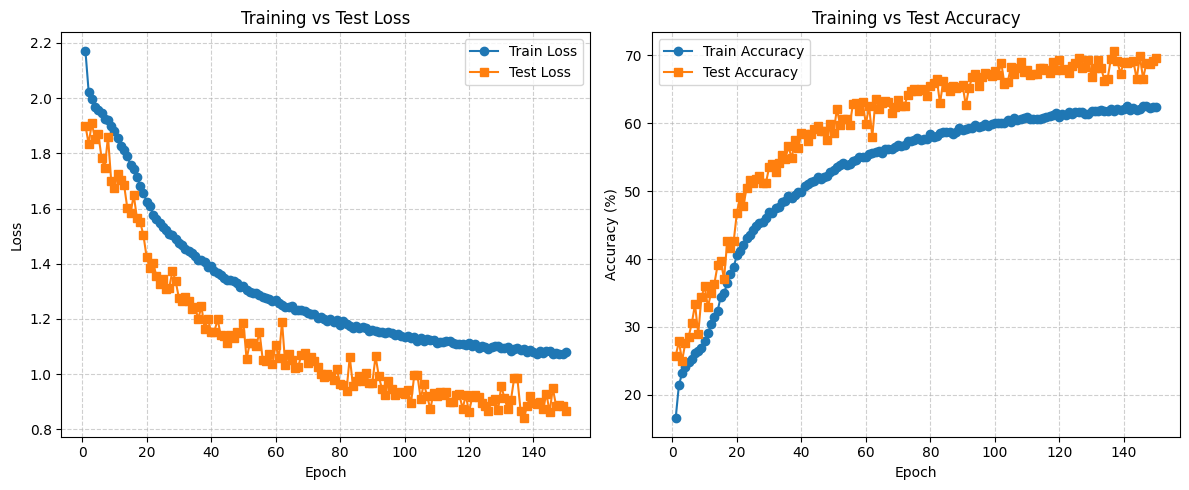

In [ ]:
# plot_metrics(fp32_metrics)

## Task 2: Quantize Squeezenet

For task 2 we use quantization aware training to quantize SqueezeNet to INT8. After training for 50 epochs we are able to achieve a final test accuracy of 69.16% with the quantized model.

In [ ]:
import numpy as np

def plot_weight_histogram(model, bins=50):
  all_weights = []

  for name, module in model.named_modules():
      if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
          weights = module.weight.detach().cpu().numpy().flatten()
          all_weights.extend(weights)

  all_weights = np.array(all_weights)

  plt.figure(figsize=(8,6))
  plt.hist(all_weights, bins=bins, color='skyblue', edgecolor='black')
  plt.title("Weight Distribution Histogram")
  plt.xlabel("Weight Value")
  plt.ylabel("Frequency")
  plt.grid(True, alpha=0.3)
  plt.show()

def evaluate(model, test_loader):
  model.eval()
  model.to('cpu')
  correct, total = 0, 0

  with torch.no_grad():
      for images, labels in test_loader:
          images, labels = images.to('cpu'), labels.to('cpu')
          outputs = model(images)
          _, pred = outputs.max(1)
          correct += pred.eq(labels).sum().item()
          total += labels.size(0)

  acc = 100.0 * correct / total
  return acc

In [ ]:
model_fp32 = SqueezeNetCIFAR10()
model_fp32.load_model("squeezenet_fp32.pth")
acc = evaluate(model_fp32,test_loader)
print(f"FP32 Test Accuracy: {acc}%")
plot_weight_histogram(model_fp32)

In [ ]:
import torch.nn as nn

class Fixed16_6FakeQuant(nn.Module):
    def __init__(self):
        super().__init__()
        self.scale = 2 ** 10  # 10 fractional bits

    def forward(self, x):
        # clip to representable range
        x = torch.clamp(x, -32, 31.999)
        # quantize
        x_q = torch.round(x * self.scale) / self.scale
        return x_q


In [ ]:
def apply_fixed_qat(module):
    for name, child in module.named_children():
        # Apply recursively
        apply_fixed_qat(child)

    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        # Wrap weights with fake quantization
        module.weight_fake_quant = Fixed16_6FakeQuant()
        module.bias_fake_quant = Fixed16_6FakeQuant() if module.bias is not None else None
        orig_forward = module.forward

        def new_forward(x, orig_forward=orig_forward, module=module):
            # Quantize weights
            w_q = module.weight_fake_quant(module.weight)
            if module.bias is not None:
                b_q = module.bias_fake_quant(module.bias)
            else:
                b_q = None
            return nn.functional.conv2d(x, w_q, bias=b_q, stride=module.stride, padding=module.padding) \
                if isinstance(module, nn.Conv2d) else nn.functional.linear(x, w_q, bias=b_q)

        module.forward = new_forward


In [ ]:
class ActivationQuant(nn.Module):
    def __init__(self):
        super().__init__()
        self.fake_quant = Fixed16_6FakeQuant()
    def forward(self, x):
        return self.fake_quant(x)

# Example: wrap activations
for name, module in model_fp32.named_modules():
    if isinstance(module, nn.ReLU):
        setattr(model_fp32, name, nn.Sequential(module, ActivationQuant()))

In [ ]:
qat_metrics = train_model(model=model_fp32,train_loader=train_loader,test_loader=test_loader,device=device,epochs=5)

In [ ]:
plot_metrics(qat_metrics)

In [ ]:
model_fp32.eval()
torch.save(model_fp32.state_dict(), "squeezenet_qat_fixed.pth")
# model_int8 = convert_fx(model_qat_prepared.cpu())
# torch.save(model_int8, "alexnet_int8_fx.pth")

In [ ]:
acc = evaluate(model_fp32,test_loader)
print(f"Fixed Point Test Accuracy: {acc}%")

In [ ]:
plot_weight_histogram(model_fp32)

In [ ]:
# import torch

# # define the fixed-point bounds
# FIXED_MIN = -8.0
# FIXED_MAX = 7.9375

# # store any violations
# violations = []

# def check_activations(module, input, output):
#     if isinstance(output, torch.Tensor):
#         if output.min() < FIXED_MIN or output.max() > FIXED_MAX:
#             violations.append((module, output.min().item(), output.max().item()))

# # register hooks on all modules
# hooks = []
# for module in model_fp32.modules():
#     # skip the model itself, focus on layers
#     if not isinstance(module, torch.nn.ModuleList) and not isinstance(module, torch.nn.Sequential):
#         hooks.append(module.register_forward_hook(check_activations))

# # run evaluation
# _ = evaluate(model_fp32, test_loader)

# # remove hooks
# for h in hooks:
#     h.remove()

# # report violations
# if len(violations) == 0:
#     print("All activations are within the ap_fixed<8,4> range [-8, 7.9375].")
# else:
#     print(f"{len(violations)} modules had activations outside the fixed-point range:")
#     for mod, vmin, vmax in violations:
#         print(f"{mod}: min={vmin}, max={vmax}")


In [ ]:
# import torch
# from torch.ao.quantization import get_default_qat_qconfig
# from torch.ao.quantization.quantize_fx import prepare_qat_fx, convert_fx

# model_qat = SqueezeNetCIFAR10()
# model_qat.load_model("squeezenet_fp32.pth", device='cpu')
# model_qat.eval()

# # example input for FX tracing
# example_inputs = (torch.randn(1, 3, 32, 32, device='cpu'),)

# # QAT config dictionary, default 8-bit symmetric QAT
# qconfig_dict = {"": get_default_qat_qconfig('fbgemm')}

# # prepare the model for QAT
# model_qat_prepared = prepare_qat_fx(model_qat, qconfig_dict, example_inputs=example_inputs)

# model_qat_prepared.to(device)
# model_qat_prepared.train()

Model loaded from squeezenet2_cifar10_fp32.pth


/tmp/SLURM_5188999/ipykernel_3829667/3130736533.py:16: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_qat_prepared = prepare_qat_fx(model_qat, qconfig_dict, example_inputs=example_inputs)
/home1/kodachi/.conda/envs/ee599/lib/python3.12/site-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and wil

GraphModule(
  (upsample): Upsample(size=224, mode='bilinear')
  (activation_post_process_0): FusedMovingAvgObsFakeQuantize(
    fake_quant_enabled=tensor([1], device='cuda:0'), observer_enabled=tensor([1], device='cuda:0'), scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
    (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
  )
  (conv1): Conv2d(
    3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)
    (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1], device='cuda:0'), observer_enabled=tensor([1], device='cuda:0'), scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
      (activation_post_process): MovingAveragePe

In [ ]:
# train, test = True, True
# epochs = 50
# qat_metrics = train_model(model=model_qat_prepared,train_loader=train_loader,test_loader=test_loader,train=train,test=test,device=device,epochs=epochs)

Epoch [1/50] 

/home1/kodachi/.conda/envs/ee599/lib/python3.12/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 1.1954, Train Acc: 57.93% 

Test/Val Loss: 0.9001, Test/Val Acc: 68.69%
Epoch [2/50] 

Train Loss: 1.1088, Train Acc: 60.65% 

Test/Val Loss: 0.9094, Test/Val Acc: 68.40%
Epoch [3/50] 

Train Loss: 1.1001, Train Acc: 61.08% 

Test/Val Loss: 1.0658, Test/Val Acc: 62.64%
Epoch [4/50] 

Train Loss: 1.0947, Train Acc: 60.96% 

Test/Val Loss: 0.8973, Test/Val Acc: 69.28%
Epoch [5/50] 

Train Loss: 1.0960, Train Acc: 61.12% 

Test/Val Loss: 0.8948, Test/Val Acc: 69.32%
Epoch [6/50] 

Train Loss: 1.0938, Train Acc: 61.24% 

Test/Val Loss: 0.9638, Test/Val Acc: 65.90%
Epoch [7/50] 

Train Loss: 1.0927, Train Acc: 61.17% 

Test/Val Loss: 0.9190, Test/Val Acc: 65.68%
Epoch [8/50] 

Train Loss: 1.0945, Train Acc: 61.28% 

Test/Val Loss: 0.9053, Test/Val Acc: 69.12%
Epoch [9/50] 

Train Loss: 1.0845, Train Acc: 61.48% 

Test/Val Loss: 0.8816, Test/Val Acc: 68.35%
Epoch [10/50] 

Train Loss: 1.0907, Train Acc: 61.27% 

Test/Val Loss: 0.8711, Test/Val Acc: 68.51%
Epoch [11/50] 

Train Loss: 1.0888, Train Acc: 61.61% 

Test/Val Loss: 0.9968, Test/Val Acc: 65.71%
Epoch [12/50] 

Train Loss: 1.0883, Train Acc: 61.42% 

Test/Val Loss: 0.9340, Test/Val Acc: 68.24%
Epoch [13/50] 

Train Loss: 1.0879, Train Acc: 61.45% 

Test/Val Loss: 0.8912, Test/Val Acc: 69.57%
Epoch [14/50] 

Train Loss: 1.0836, Train Acc: 61.43% 

Test/Val Loss: 0.8645, Test/Val Acc: 69.74%
Epoch [15/50] 

Train Loss: 1.0910, Train Acc: 61.36% 

Test/Val Loss: 0.8898, Test/Val Acc: 69.70%
Epoch [16/50] 

Train Loss: 1.0846, Train Acc: 61.48% 

Test/Val Loss: 0.8967, Test/Val Acc: 68.44%
Epoch [17/50] 

Train Loss: 1.0835, Train Acc: 61.55% 

Test/Val Loss: 0.8529, Test/Val Acc: 69.43%
Epoch [18/50] 

Train Loss: 1.0937, Train Acc: 61.03% 

Test/Val Loss: 0.8700, Test/Val Acc: 69.48%
Epoch [19/50] 

Train Loss: 1.0754, Train Acc: 61.67% 

Test/Val Loss: 0.8818, Test/Val Acc: 69.71%
Epoch [20/50] 

Train Loss: 1.1014, Train Acc: 60.90% 

Test/Val Loss: 0.8771, Test/Val Acc: 68.91%
Epoch [21/50] 

Train Loss: 1.0786, Train Acc: 61.57% 

Test/Val Loss: 0.8946, Test/Val Acc: 69.74%
Epoch [22/50] 

Train Loss: 1.0878, Train Acc: 61.41% 

Test/Val Loss: 0.9168, Test/Val Acc: 67.92%
Epoch [23/50] 

Train Loss: 1.0755, Train Acc: 61.72% 

Test/Val Loss: 0.8770, Test/Val Acc: 69.10%
Epoch [24/50] 

Train Loss: 1.0838, Train Acc: 61.24% 

Test/Val Loss: 0.8440, Test/Val Acc: 69.11%
Epoch [25/50] 

Train Loss: 1.0834, Train Acc: 61.55% 

Test/Val Loss: 0.8670, Test/Val Acc: 69.18%
Epoch [26/50] 

Train Loss: 1.0804, Train Acc: 61.57% 

Test/Val Loss: 1.0599, Test/Val Acc: 65.52%
Epoch [27/50] 

Train Loss: 1.0778, Train Acc: 61.82% 

Test/Val Loss: 1.0161, Test/Val Acc: 62.76%
Epoch [28/50] 

Train Loss: 1.0767, Train Acc: 61.57% 

Test/Val Loss: 0.8830, Test/Val Acc: 68.09%
Epoch [29/50] 

Train Loss: 1.0782, Train Acc: 61.85% 

Test/Val Loss: 0.8559, Test/Val Acc: 69.16%
Epoch [30/50] 

Train Loss: 1.0807, Train Acc: 61.67% 

Test/Val Loss: 0.8873, Test/Val Acc: 68.67%
Epoch [31/50] 

Train Loss: 1.0807, Train Acc: 61.63% 

Test/Val Loss: 0.8476, Test/Val Acc: 70.07%
Epoch [32/50] 

Train Loss: 1.0712, Train Acc: 61.96% 

Test/Val Loss: 0.8604, Test/Val Acc: 68.49%
Epoch [33/50] 

Train Loss: 1.0769, Train Acc: 61.72% 

Test/Val Loss: 0.8675, Test/Val Acc: 68.91%
Epoch [34/50] 

Train Loss: 1.0763, Train Acc: 61.88% 

Test/Val Loss: 0.8761, Test/Val Acc: 69.29%
Epoch [35/50] 

Train Loss: 1.0728, Train Acc: 61.90% 

Test/Val Loss: 0.9051, Test/Val Acc: 67.54%
Epoch [36/50] 

Train Loss: 1.0705, Train Acc: 62.04% 

Test/Val Loss: 0.8949, Test/Val Acc: 67.51%
Epoch [37/50] 

Train Loss: 1.0765, Train Acc: 61.41% 

Test/Val Loss: 0.8750, Test/Val Acc: 67.80%
Epoch [38/50] 

Train Loss: 1.0671, Train Acc: 62.03% 

Test/Val Loss: 0.8687, Test/Val Acc: 69.73%
Epoch [39/50] 

Train Loss: 1.0741, Train Acc: 61.84% 

Test/Val Loss: 0.8496, Test/Val Acc: 70.02%
Epoch [40/50] 

Train Loss: 1.0681, Train Acc: 62.01% 

Test/Val Loss: 0.8968, Test/Val Acc: 68.10%
Epoch [41/50] 

Train Loss: 1.0742, Train Acc: 61.70% 

Test/Val Loss: 0.8713, Test/Val Acc: 69.24%
Epoch [42/50] 

Train Loss: 1.0687, Train Acc: 62.29% 

Test/Val Loss: 0.9350, Test/Val Acc: 67.24%
Epoch [43/50] 

Train Loss: 1.0720, Train Acc: 62.04% 

Test/Val Loss: 0.8606, Test/Val Acc: 70.15%
Epoch [44/50] 

Train Loss: 1.0687, Train Acc: 61.85% 

Test/Val Loss: 0.8726, Test/Val Acc: 69.95%
Epoch [45/50] 

Train Loss: 1.0660, Train Acc: 62.41% 

Test/Val Loss: 0.8443, Test/Val Acc: 70.31%
Epoch [46/50] 

Train Loss: 1.0689, Train Acc: 61.96% 

Test/Val Loss: 0.8297, Test/Val Acc: 70.98%
Epoch [47/50] 

Train Loss: 1.0560, Train Acc: 62.61% 

Test/Val Loss: 0.8557, Test/Val Acc: 71.03%
Epoch [48/50] 

Train Loss: 1.0656, Train Acc: 62.04% 

Test/Val Loss: 0.8580, Test/Val Acc: 69.86%
Epoch [49/50] 

Train Loss: 1.0674, Train Acc: 62.06% 

Test/Val Loss: 1.0367, Test/Val Acc: 62.28%
Epoch [50/50] 

Train Loss: 1.0612, Train Acc: 62.26% 

Test/Val Loss: 0.9031, Test/Val Acc: 69.23%


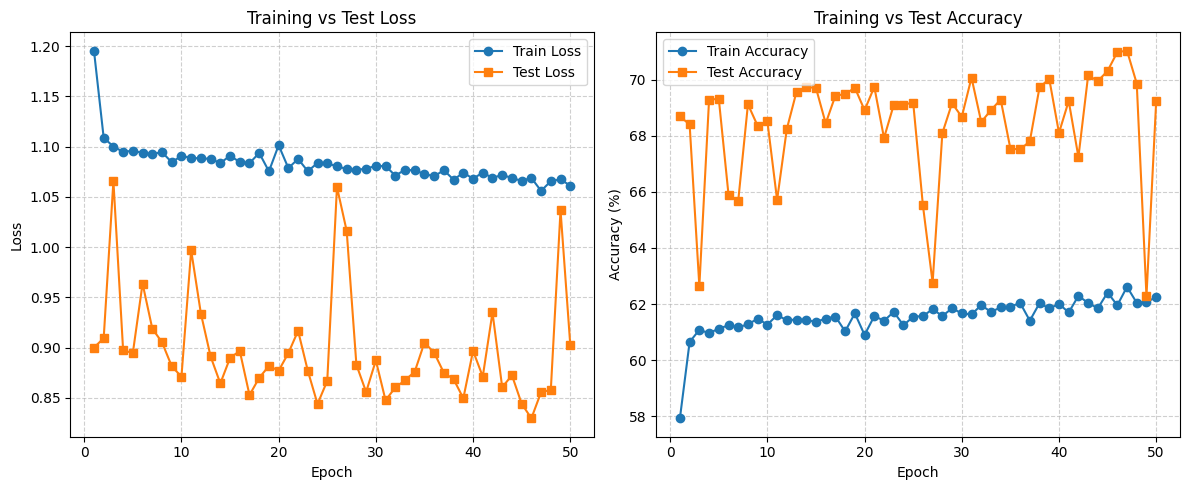

In [ ]:
# plot_metrics(qat_metrics)

In [ ]:
# # convert to INT8
# model_qat_prepared.eval()
# model_int8 = convert_fx(model_qat_prepared.cpu())
# torch.save(model_int8.state_dict(), "squeezenet_qat.pth")
# # model_int8.load_state_dict(torch.load("squeezenet_int8_qat.pth"))
# # model_int8.eval()

/tmp/SLURM_5188999/ipykernel_3829667/1243580762.py:3: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_int8 = convert_fx(model_qat_prepared.cpu())


In [ ]:
# def evaluate(model, test_loader):
#     model.eval()
#     model.to('cpu')
#     correct, total = 0, 0

#     with torch.no_grad():
#         for images, labels in test_loader:
#             images, labels = images.to('cpu'), labels.to('cpu')
#             outputs = model(images)
#             _, pred = outputs.max(1)
#             correct += pred.eq(labels).sum().item()
#             total += labels.size(0)

#     acc = 100.0 * correct / total
#     return acc

# acc = evaluate(model_int8,test_loader)
# print(f"INT8 Test Accuracy: {acc}%")

INT8 Test Accuracy: 69.16%
